using vader, roberta pretrained model and hugging face pipeline

Import data and NLTK basics

In [6]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
import random
import nltk
nltk.download('punkt')  # Ensure the standard punkt tokenizer is installed
nltk.download('averaged_perceptron_tagger')  # Sometimes required for tokenization




[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\RajBu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\RajBu\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [7]:
df = pd.read_csv('hate_train.csv')
print(df.shape)
df = df.head(500)
print(df.head(500))

(9000, 2)
                                                  text  label
0    @user nice new signage. Are you not concerned ...      0
1    A woman who you fucked multiple times saying y...      1
2    @user @user real talk do you have eyes or were...      1
3    your girlfriend lookin at me like a groupie in...      1
4                          Hysterical woman like @user      0
..                                                 ...    ...
495  @user Julian, you are currently hiding in a cu...      0
496  honey, it's not you vs. skank. It's you versus...      0
497  @user you are a big piece of white trash you f...      0
498  Mr Shorter - scum bag posting things like this...      0
499  #WakeUpAmerica~> #WalkAwayFromDemocrats @user ...      1

[500 rows x 2 columns]


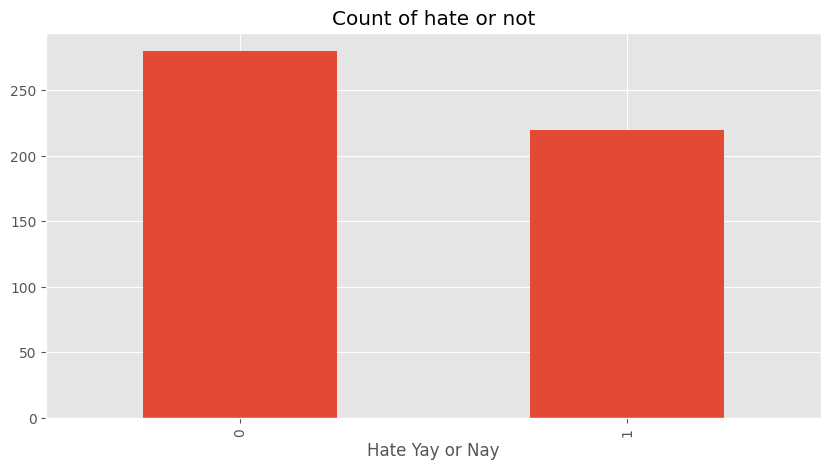

In [8]:
ax = df['label'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of hate or not',
          figsize=(10, 5))
ax.set_xlabel('Hate Yay or Nay')
plt.show()

In [9]:
example = df['text'][random.randint(0, 500)]
print(example)

ICE: 124 illegal immigrants released from jail later charged in 138 murder cases #BuildTheWall #EnforceUSLaws#KeepAmericansSafeThis is all the Congress should be comtemplating!#BanSanctuaryCities #NoAmnesty #NoDACADeal #EndChainMigration #Deport


In [10]:
tokens = nltk.word_tokenize(example)
print(tokens[:10])


['ICE', ':', '124', 'illegal', 'immigrants', 'released', 'from', 'jail', 'later', 'charged']
